In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ekspolrasi data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Customer Clustering/Mall_Customers.csv')

print(data.head())
print(data.info())
print(f"Jumlah baris: {data.shape[0]}, Jumlah kolom: {data.shape[1]}")
print(data.describe())
print(data.dtypes)

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
Jumlah baris: 200, Jumlah kolom: 5
       CustomerI



*   Cek duplikat



In [ ]:
print(f"Jumlah duplikat: {df.duplicated().sum()}")

Jumlah duplikat: 0




*   Cek outlier


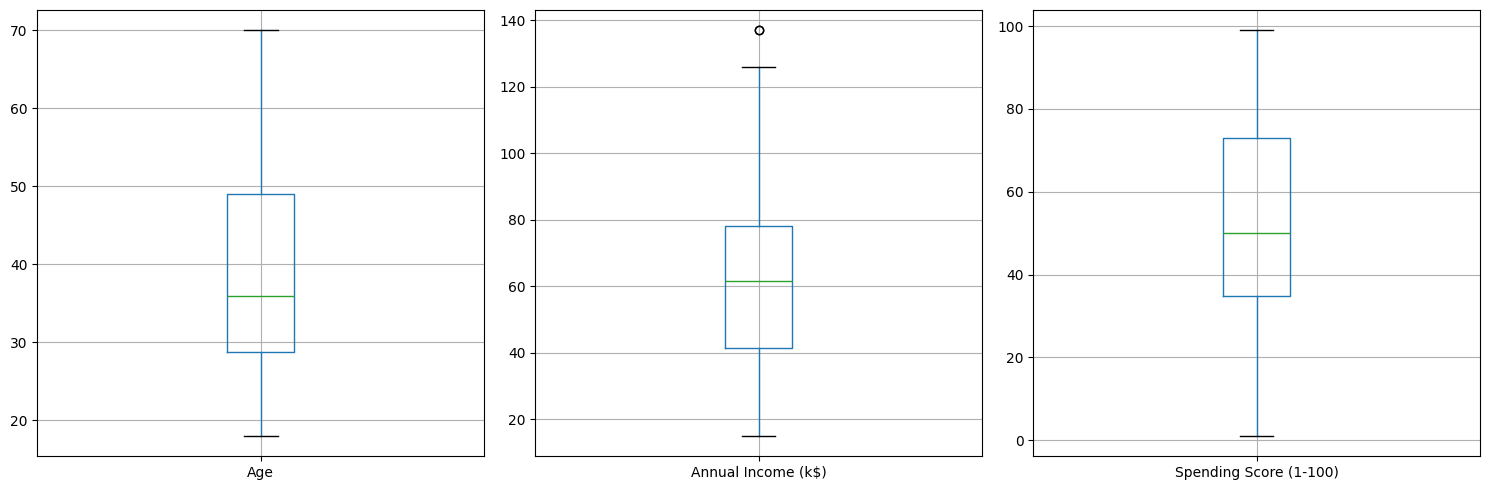

Jumlah outliers: 0


In [ ]:
# Boxplot untuk identifikasi outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
data.boxplot(column='Age', ax=axes[0])
data.boxplot(column='Annual Income (k$)', ax=axes[1])
data.boxplot(column='Spending Score (1-100)', ax=axes[2])
plt.tight_layout()
plt.show()

# Z-score method untuk outliers
from scipy.stats import zscore
z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).any(axis=1)
print(f"Jumlah outliers: {outliers.sum()}")




*   Data Normalization



In [ ]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features]

# Min-Max Normalization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Convert ke DataFrame
data_normalized = pd.DataFrame(X_normalized, columns=features)

# Tambahkan kolom CustomerID dan Gender (tidak dinormalisasi)
data_normalized.insert(0, 'CustomerID', data['CustomerID'])
data_normalized.insert(1, 'Gender', data['Gender'])

# Save ke CSV
data_normalized.to_csv('/content/drive/MyDrive/Customer Clustering/Mall_Customers_Normalized.csv', index=False)

# Pemilihan fitur



*   Variance analisis



In [ ]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
variances = data[features].var()
print("Variance setiap fitur:")
print(variances)

# Hapus fitur dengan varians sangat rendah
threshold = 0.05
selected_features = variances[variances > threshold].index.tolist()
X = data[selected_features]

print(f"Fitur terpilih: {selected_features}")

Variance setiap fitur:
Age                       0.072165
Annual Income (k$)        0.046347
Spending Score (1-100)    0.069435
dtype: float64
Fitur terpilih: ['Age', 'Spending Score (1-100)']




*   Correlation analisis



In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mall_Customers_Normalized.csv')

# Pilih fitur numerik
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Hitung correlation matrix
corr_matrix = data[features].corr()

print("=== CORRELATION ANALYSIS ===\n")
print("Correlation Matrix:")
print(corr_matrix)
print()

high_corr_found = False

for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_value = abs(corr_matrix.iloc[i, j])
        feat1 = features[i]
        feat2 = features[j]

        if corr_value > 0.3:
            print(f"✗ {feat1} <-> {feat2}: {corr_value:.4f}")
            high_corr_found = True
        else:
            print(f"✓ {feat1} <-> {feat2}: {corr_value:.4f}")


=== CORRELATION ANALYSIS ===

Correlation Matrix:
                             Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000

✓ Age <-> Annual Income (k$): 0.0124
✗ Age <-> Spending Score (1-100): 0.3272
✓ Annual Income (k$) <-> Spending Score (1-100): 0.0099


# Modeling



*   K means



=== STEP 1: MENENTUKAN K OPTIMAL ===



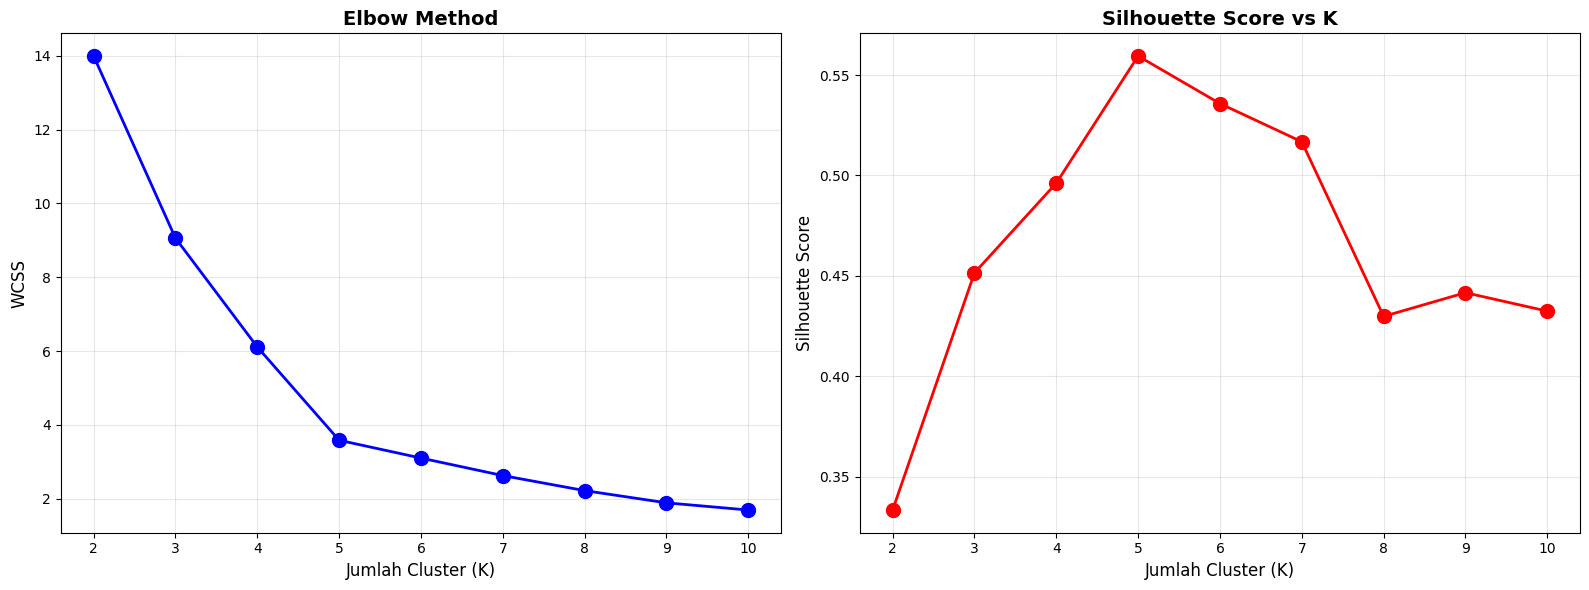

K optimal berdasarkan Silhouette Score: K = 5
Silhouette Score tertinggi: 0.5595

=== STEP 2: K-MEANS CLUSTERING ===

Clustering selesai dengan K = 5

Jumlah pelanggan per cluster:
Cluster
0    22
1    35
2    39
3    81
4    23
Name: count, dtype: int64

EVALUASI MODEL K-MEANS

1. Silhouette Score: 0.5595
   Range: -1 to 1
   Interpretasi: Baik

2. Davies-Bouldin Index: 0.5678
   Range: 0 to ∞
   Interpretasi: Sangat Baik

3. Inertia (WCSS): 3.58
   Semakin kecil semakin baik

VISUALISASI HASIL CLUSTERING



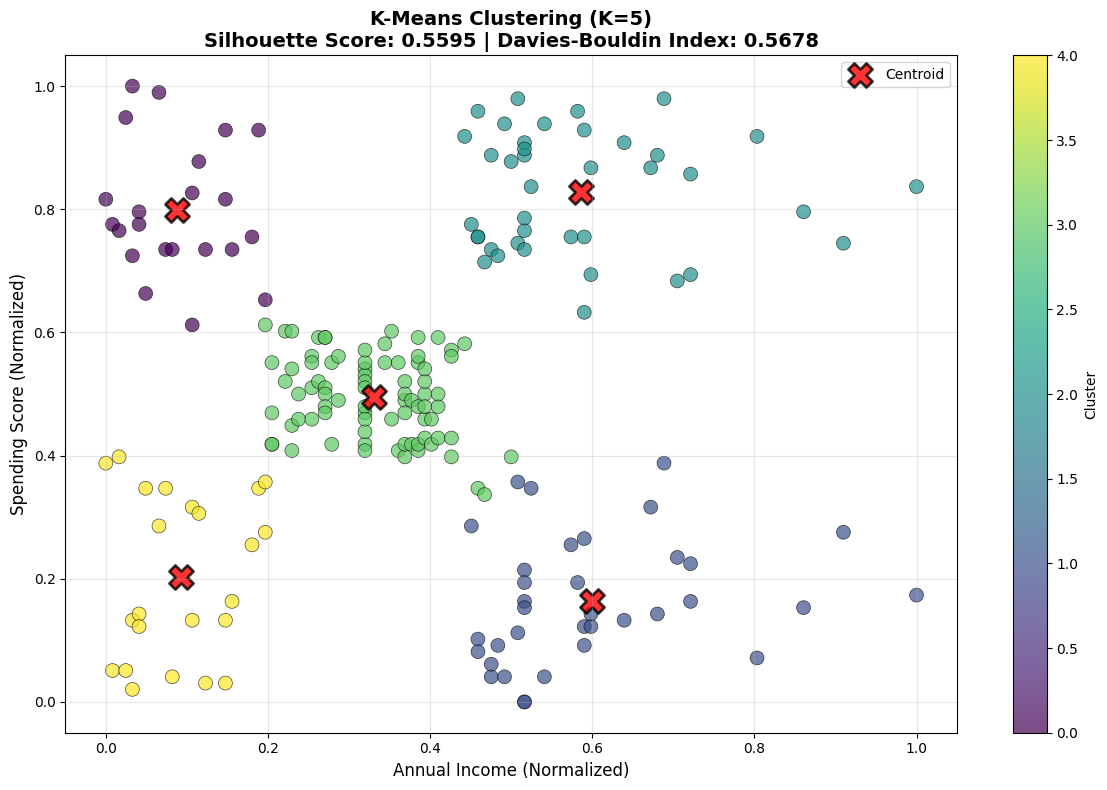

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mall_Customers_Normalized.csv')

# ===== STEP 1: ELBOW METHOD & SILHOUETTE UNTUK TENTUKAN K OPTIMAL =====
print("=== STEP 1: MENENTUKAN K OPTIMAL ===\n")

X = data[['Annual Income (k$)', 'Spending Score (1-100)']]

wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

    labels = kmeans.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    silhouette_scores.append(silhouette)

# Visualisasi Elbow Method & Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Elbow Method
axes[0].plot(K_range, wcss, 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('Jumlah Cluster (K)', fontsize=12)
axes[0].set_ylabel('WCSS', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

# Plot Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('Jumlah Cluster (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)

plt.tight_layout()
plt.show()

# Rekomendasi K optimal
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"K optimal berdasarkan Silhouette Score: K = {optimal_k}")
print(f"Silhouette Score tertinggi: {max(silhouette_scores):.4f}\n")

# ===== STEP 2: K-MEANS CLUSTERING DENGAN K OPTIMAL =====
print("=== STEP 2: K-MEANS CLUSTERING ===\n")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['Cluster'] = kmeans_final.fit_predict(X)

print(f"Clustering selesai dengan K = {optimal_k}")
print(f"\nJumlah pelanggan per cluster:")
print(data['Cluster'].value_counts().sort_index())
print()

# ===== STEP 3: EVALUASI MODEL =====
print("=" * 80)
print("EVALUASI MODEL K-MEANS")
print("=" * 80)

labels = data['Cluster']

# Silhouette Score
silhouette = silhouette_score(X, labels)
print(f"\n1. Silhouette Score: {silhouette:.4f}")
print(f"   Range: -1 to 1")
print(f"   Interpretasi:", end=" ")
if silhouette > 0.7:
    print("Sangat Baik")
elif silhouette > 0.5:
    print("Baik")
elif silhouette > 0.25:
    print("Lemah")
else:
    print("Buruk")

# Davies-Bouldin Index
dbi = davies_bouldin_score(X, labels)
print(f"\n2. Davies-Bouldin Index: {dbi:.4f}")
print(f"   Range: 0 to ∞")
print(f"   Interpretasi:", end=" ")
if dbi < 1.0:
    print("Sangat Baik")
elif dbi < 2.0:
    print("Baik")
else:
    print("Kurang Baik")

# Inertia (WCSS)
inertia = kmeans_final.inertia_
print(f"\n3. Inertia (WCSS): {inertia:.2f}")
print(f"   Semakin kecil semakin baik")

# ===== STEP 4: VISUALISASI HASIL CLUSTERING =====
print("\n" + "=" * 80)
print("VISUALISASI HASIL CLUSTERING")
print("=" * 80 + "\n")

# Scatter plot hasil clustering
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['Annual Income (k$)'],
                     data['Spending Score (1-100)'],
                     c=data['Cluster'],
                     cmap='viridis',
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)

# Plot centroid
centroids = kmeans_final.cluster_centers_
plt.scatter(centroids[:, 0],
           centroids[:, 1],
           c='red',
           s=300,
           alpha=0.8,
           marker='X',
           edgecolors='black',
           linewidth=2,
           label='Centroid')

plt.xlabel('Annual Income (Normalized)', fontsize=12)
plt.ylabel('Spending Score (Normalized)', fontsize=12)
plt.title(f'K-Means Clustering (K={optimal_k})\nSilhouette Score: {silhouette:.4f} | Davies-Bouldin Index: {dbi:.4f}',
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



*   DBSCAN


=== STEP 1: K-DISTANCE GRAPH ===



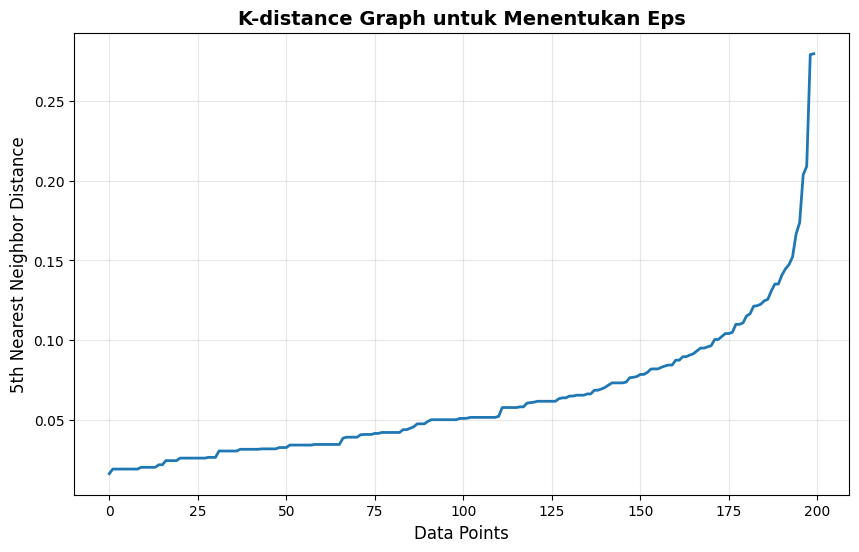

Perhatikan grafik: Cari titik 'siku' untuk menentukan eps optimal

=== STEP 2: TESTING PARAMETER DBSCAN ===

eps	min_samples	Clusters	Noise	Silhouette	Davies-Bouldin
--------------------------------------------------------------------------------
0.05	3		13		42	0.4747		0.5059
0.05	4		9		65	0.4594		0.5348
0.05	5		6		79	0.6134		0.4377
0.05	6		4		92	0.6301		0.3966
0.05	7		3		107	0.6093		0.3708
0.1	3		3		10	0.3568		0.6285
0.1	4		2		13	0.4045		0.7308
0.1	5		3		14	0.3537		0.7000
0.1	6		3		18	0.3703		0.6764
0.1	7		4		18	0.5045		0.5632

PARAMETER OPTIMAL

Berdasarkan Silhouette Score (tertinggi):
  eps = 0.05
  min_samples = 6
  Clusters = 4
  Noise = 92
  Silhouette Score = 0.6301

Berdasarkan Davies-Bouldin Index (terendah):
  eps = 0.05
  min_samples = 7
  Clusters = 3
  Noise = 107
  Davies-Bouldin Index = 0.3708

DBSCAN CLUSTERING

Clustering selesai dengan eps=0.05, min_samples=6
Jumlah cluster: 4
Jumlah noise points: 92

Jumlah pelanggan per cluster:
Cluster
-1    92
 0    78
 1    10
 

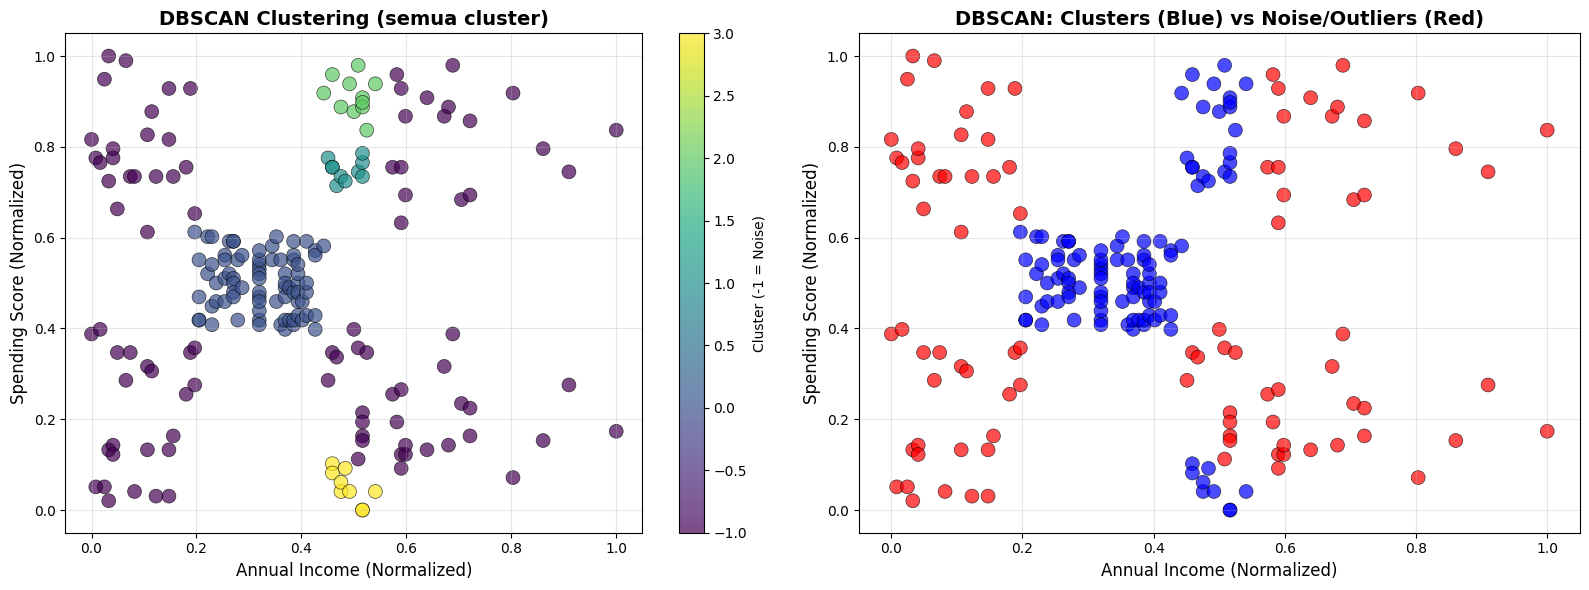

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mall_Customers_Normalized.csv')

X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values

# ===== STEP 1: K-DISTANCE GRAPH UNTUK TENTUKAN EPS =====
print("=== STEP 1: K-DISTANCE GRAPH ===\n")

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances_sorted = np.sort(distances[:, 4], axis=0)

# Plot K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances_sorted, linewidth=2)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('5th Nearest Neighbor Distance', fontsize=12)
plt.title('K-distance Graph untuk Menentukan Eps', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print("Perhatikan grafik: Cari titik 'siku' untuk menentukan eps optimal\n")

# ===== STEP 2: TEST BERBAGAI PARAMETER DBSCAN =====
print("=== STEP 2: TESTING PARAMETER DBSCAN ===\n")

eps_range = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
min_samples_range = [3, 4, 5, 6, 7]

results = []

print("eps\tmin_samples\tClusters\tNoise\tSilhouette\tDavies-Bouldin")
print("-" * 80)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Hanya hitung metrik jika ada minimal 2 cluster dan ada data non-noise
        if n_clusters > 1:
            mask = labels != -1
            if sum(mask) > 1:
                silhouette = silhouette_score(X[mask], labels[mask])
                dbi = davies_bouldin_score(X[mask], labels[mask])

                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette,
                    'dbi': dbi
                })

                print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t{silhouette:.4f}\t\t{dbi:.4f}")

# Convert results ke DataFrame
df_results = pd.DataFrame(results)

# Cari parameter optimal
best_silhouette_idx = df_results['silhouette'].idxmax()
best_dbi_idx = df_results['dbi'].idxmin()

print()

# ===== STEP 3: PARAMETER OPTIMAL =====
print("=" * 80)
print("PARAMETER OPTIMAL")
print("=" * 80 + "\n")

print("Berdasarkan Silhouette Score (tertinggi):")
print(f"  eps = {df_results.loc[best_silhouette_idx, 'eps']}")
print(f"  min_samples = {int(df_results.loc[best_silhouette_idx, 'min_samples'])}")
print(f"  Clusters = {int(df_results.loc[best_silhouette_idx, 'n_clusters'])}")
print(f"  Noise = {int(df_results.loc[best_silhouette_idx, 'n_noise'])}")
print(f"  Silhouette Score = {df_results.loc[best_silhouette_idx, 'silhouette']:.4f}")

print("\nBerdasarkan Davies-Bouldin Index (terendah):")
print(f"  eps = {df_results.loc[best_dbi_idx, 'eps']}")
print(f"  min_samples = {int(df_results.loc[best_dbi_idx, 'min_samples'])}")
print(f"  Clusters = {int(df_results.loc[best_dbi_idx, 'n_clusters'])}")
print(f"  Noise = {int(df_results.loc[best_dbi_idx, 'n_noise'])}")
print(f"  Davies-Bouldin Index = {df_results.loc[best_dbi_idx, 'dbi']:.4f}")
print()

# ===== STEP 4: CLUSTERING DENGAN PARAMETER OPTIMAL =====
print("=" * 80)
print("DBSCAN CLUSTERING")
print("=" * 80 + "\n")

best_params = df_results.loc[best_silhouette_idx]
dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
labels = dbscan_final.fit_predict(X)

# Tambahkan cluster ke data
data['Cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Clustering selesai dengan eps={best_params['eps']}, min_samples={int(best_params['min_samples'])}")
print(f"Jumlah cluster: {n_clusters}")
print(f"Jumlah noise points: {n_noise}")
print(f"\nJumlah pelanggan per cluster:")
print(data['Cluster'].value_counts().sort_index())
print()

# ===== STEP 5: EVALUASI MODEL =====
print("=" * 80)
print("EVALUASI MODEL DBSCAN")
print("=" * 80)

# Silhouette Score (hanya untuk non-noise)
mask = labels != -1
if sum(mask) > 1:
    silhouette = silhouette_score(X[mask], labels[mask])
    print(f"\n1. Silhouette Score: {silhouette:.4f}")
    print(f"   Range: -1 to 1")
    print(f"   Interpretasi:", end=" ")
    if silhouette > 0.7:
        print("Sangat Baik")
    elif silhouette > 0.5:
        print("Baik")
    elif silhouette > 0.25:
        print("Lemah")
    else:
        print("Buruk")
else:
    print("\n1. Silhouette Score: Tidak dapat dihitung (data noise terlalu banyak)")

# Davies-Bouldin Index (hanya untuk non-noise)
if sum(mask) > 1:
    dbi = davies_bouldin_score(X[mask], labels[mask])
    print(f"\n2. Davies-Bouldin Index: {dbi:.4f}")
    print(f"   Range: 0 to ∞")
    print(f"   Interpretasi:", end=" ")
    if dbi < 1.0:
        print("Sangat Baik")
    elif dbi < 2.0:
        print("Baik")
    else:
        print("Kurang Baik")
else:
    print("\n2. Davies-Bouldin Index: Tidak dapat dihitung (data noise terlalu banyak)")

# Informasi noise
print(f"\n3. Noise Points: {n_noise} ({n_noise/len(data)*100:.1f}%)")
print(f"   Outlier/Anomali yang terdeteksi")

# ===== STEP 6: VISUALISASI HASIL =====
print("\n" + "=" * 80)
print("VISUALISASI HASIL CLUSTERING")
print("=" * 80 + "\n")

# Plot 1: Semua cluster dengan noise
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(data['Annual Income (k$)'],
                           data['Spending Score (1-100)'],
                           c=data['Cluster'],
                           cmap='viridis',
                           s=100,
                           alpha=0.7,
                           edgecolors='black',
                           linewidth=0.5)
axes[0].set_xlabel('Annual Income (Normalized)', fontsize=12)
axes[0].set_ylabel('Spending Score (Normalized)', fontsize=12)
axes[0].set_title('DBSCAN Clustering (semua cluster)', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster (-1 = Noise)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Highlight noise points
colors = ['red' if x == -1 else 'blue' for x in data['Cluster']]
axes[1].scatter(data['Annual Income (k$)'],
                data['Spending Score (1-100)'],
                c=colors,
                s=100,
                alpha=0.7,
                edgecolors='black',
                linewidth=0.5)
axes[1].set_xlabel('Annual Income (Normalized)', fontsize=12)
axes[1].set_ylabel('Spending Score (Normalized)', fontsize=12)
axes[1].set_title('DBSCAN: Clusters (Blue) vs Noise/Outliers (Red)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()